In [9]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, in_context_from_samples, test_prompt_from_samples, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_complete"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 67,
 'all_upper': 59,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'start_cap': 133,
 'start_lower': 67,
 'start_the': 57}


In [10]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["sentence"]
tags_false = ["fragment_subject", "fragment_verb"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common)

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

160 40


In [11]:
pprint(positives)

[{'input': 'WINTER BRINGS SNOW AND FROSTY MORNINGS.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'even_words',
           'gpt4']},
 {'input': 'Gardening provides a connection to nature.',
  'label': True,
  'tags': ['even_words', 'start_cap', 'sentence', 'gpt4']},
 {'input': "As the sun set, the city's skyline transformed into a mesmerizing "
           'display of colors and shadows.',
  'label': True,
  'tags': ['city', 'start_cap', 'sentence', 'even_words', 'gpt4']},
 {'input': 'London Bridge is an iconic landmark.',
  'label': True,
  'tags': ['city',
           'start_cap',
           'sentence',
           'even_words',
           'gpt4',
           'proper_noun']},
 {'input': 'green tea has many health benefits.',
  'label': True,
  'tags': ['all_lower', 'sentence', 'even_words', 'start_lower', 'gpt4']},
 {'input': 'IN THE END, WE WILL REMEMBER NOT THE WORDS OF OUR ENEMIES, 

In [12]:
pprint(negatives)

[{'input': 'drifting through the open meadow',
  'label': False,
  'tags': ['all_lower',
           'fragment_verb',
           'nature',
           'odd_words',
           'start_lower',
           'gpt4']},
 {'input': 'gentle raindrops tapping on the window',
  'label': False,
  'tags': ['all_lower',
           'fragment_subject',
           'even_words',
           'start_lower',
           'gpt4']},
 {'input': 'A solitary figure silhouetted against the sunset',
  'label': False,
  'tags': ['odd_words', 'start_cap', 'fragment_subject', 'gpt4']},
 {'input': 'Sunset casting a warm glow over the horizon',
  'label': False,
  'tags': ['start_cap', 'fragment_subject', 'nature', 'even_words', 'gpt4']},
 {'input': 'A treasure map with mysterious markings',
  'label': False,
  'tags': ['even_words', 'start_cap', 'fragment_subject', 'gpt4']},
 {'input': 'suspended in the vastness of space',
  'label': False,
  'tags': ['all_lower',
           'fragment_verb',
           'nature',
           

In [15]:
def write_test_data(positives, negatives, samples_per_label):
    num_test_samples = min(len(positives), len(negatives)) - samples_per_label

    in_context_samples = positives[:samples_per_label] + negatives[:samples_per_label]
    in_context_prompt = in_context_from_samples(in_context_samples)
    with open(output_dir / f"in_context_prompt_{samples_per_label}.txt", "w") as f:
        f.write(in_context_prompt)

    test_positives = positives[samples_per_label:][:num_test_samples]
    test_negatives = negatives[samples_per_label:][:num_test_samples]
    test_prompt, test_samples = test_prompt_from_samples(test_positives, test_negatives)
    with open(output_dir / f"test_prompt_{samples_per_label}.txt", "w") as f:
        f.write(test_prompt)
    json.dump(test_samples, open(output_dir / f"test_samples_{samples_per_label}.json", "w"), indent=2)

In [25]:
sample_counts = [5, 10, 15]
response_jsons = []
for c in sample_counts:
    write_test_data(positives, negatives, c)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:85: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:86: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:89: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:90: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [26]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [27]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.7162162162162162,
  'correct': 53,
  'corrupted': 0,
  'in_context_count': 3,
  'incorrect': 21,
  'mismatch': 0,
  'total': 74},
 {'accuracy': 1.0,
  'correct': 70,
  'corrupted': 0,
  'in_context_count': 5,
  'incorrect': 0,
  'mismatch': 0,
  'total': 70},
 {'accuracy': 0.9166666666666666,
  'correct': 55,
  'corrupted': 0,
  'in_context_count': 10,
  'incorrect': 5,
  'mismatch': 0,
  'total': 60},
 {'accuracy': 0.92,
  'correct': 46,
  'corrupted': 0,
  'in_context_count': 15,
  'incorrect': 4,
  'mismatch': 0,
  'total': 50}]


In [28]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                      
3.121622          0.716216       0.0   0.283784        0.0    0.961039
5.500000          1.000000       0.0   0.000000        0.0    0.909091
12.833333         0.916667       0.0   0.083333        0.0    0.779221
23.100000         0.920000       0.0   0.080000        0.0    0.649351


Text(0.5, 1.0, 'Complete senteces vs Sentence fragments (n=77, T=1)')

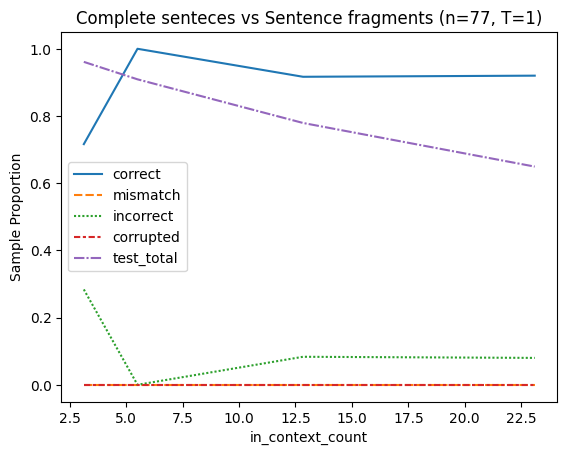

In [34]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col == "total":
        df[col] /= total_samples
    else:
        df[col] /= df["total"]
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Complete senteces vs Sentence fragments (n={total_samples}, T=1)")